# Preparing

In [1]:
import os
import pathlib

import torch
from torch import nn
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Training on {device}')

Training on cuda


In [3]:
class Prepare_data():
    def __init__(self):
        self.dataset = None
        self.transform = None

    def load_data(self, path):
        test_classes = {'Rook': 0, 'Queen': 1, 'Pawn': 2, 'Bishop': 3, 'Knight': 4}
        dataset = []

        for name_class in os.listdir(path):
            try:
                encod_class = test_classes[name_class]
            except KeyError:
                print(f'Wrong class {name_class}')
                continue

            for picture in os.listdir(os.path.join(path, name_class)):
                try:
                    image = Image.open(os.path.join(path, name_class, picture)).convert('RGB')
                    transform_resized = transforms.Compose([transforms.Resize((224, 224)),
                                                          transforms.ToTensor()])
                    image = transform_resized(image)
                    if image.sum() <= 50:
                        continue
                    dataset.append((image, encod_class))
                except:
                    print(f'Wrong file {os.path.join(path, name_class, picture)}')

        self.dataset = dataset

    def get_loaders(self, train_size=0.7, val_test_ratio=0.5, batch_size=18, transform=None):
        self.transform = transform
        
        num_samples = len(self.dataset)
        indices = list(range(num_samples))
        np.random.shuffle(indices)

        train_size = int(len(indices) * train_size)
        train_idx, holdout_idx = indices[:train_size], indices[train_size:]

        val_size = int(len(holdout_idx) * val_test_ratio)
        val_idx, test_idx = holdout_idx[:val_size], holdout_idx[val_size:]

        if transform:
            for idx in train_idx:
                self.dataset[idx][0] = transform(self.dataset[idx][0])

        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        test_sampler = SubsetRandomSampler(test_idx)

        train_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=val_sampler)
        test_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=test_sampler)

        return (train_loader, val_loader, test_loader)


In [4]:
data_dir = '/content/drive/MyDrive/My_dataset_comp/data_Chess/data'

transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomPerspective(),
                                transforms.RandomVerticalFlip()])
train_size = 0.7
val_test_ratio = 0.5
batch_size = 12

decode_classes = {0: 'rook(башня)', 1: 'queen(королева)', 2: 'pawn(пешка)', 3: 'bishop(слон)', 4: 'knight(конь)'}

In [5]:
my_test = Prepare_data()
my_test.load_data(data_dir)

In [6]:
train_loader, val_loader, test_loader = my_test.get_loaders(train_size=train_size,
                                                            val_test_ratio=val_test_ratio,
                                                            batch_size=batch_size)

In [7]:
print(f'Size of training set is {len(train_loader) * batch_size}')
print(f'Size of validate set is {len(val_loader) * batch_size}')
print(f'Size of testing set is {len(test_loader) * batch_size}')

Size of training set is 792
Size of validate set is 180
Size of testing set is 180


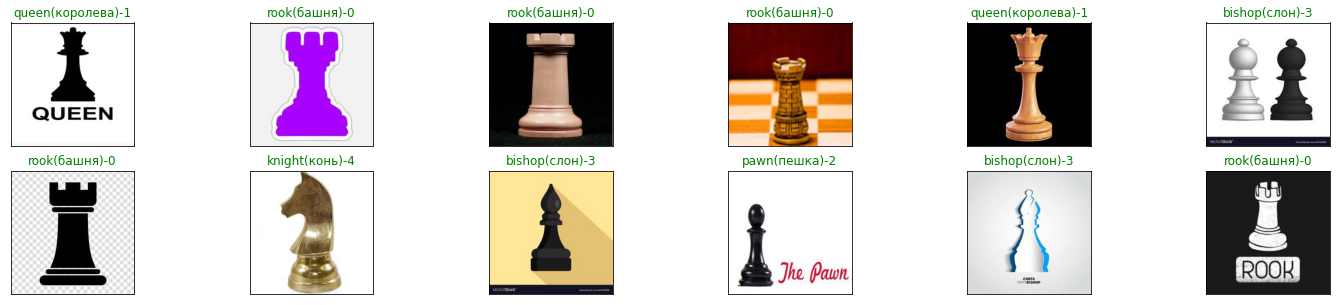

In [8]:
image, labels = next(iter(train_loader))
image = image.numpy()

fig = plt.figure(figsize=(25, 5))
num_picture = 18 if batch_size > 18 else batch_size
num_picture = num_picture if num_picture % 2 == 0 else num_picture - 1

for idx in np.arange(num_picture):
    ax = fig.add_subplot(2, num_picture // 2, idx + 1, xticks=[], yticks=[])
    plt.imshow(image[idx].transpose((1, 2, 0)))
    ax.set_title(decode_classes[labels[idx].item()] + '-' + str(labels[idx].item()), color='green')

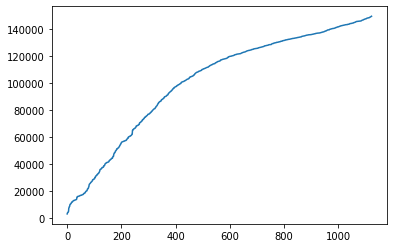

In [9]:
black_dict = {}
for i in np.arange(len(my_test.dataset)):
    black_dict[i] = int(my_test.dataset[i][0].sum().item())

black_dict = dict(sorted(black_dict.items(), key=lambda key: key[1]))
plt.plot(range(len(black_dict)), list(black_dict.values()))

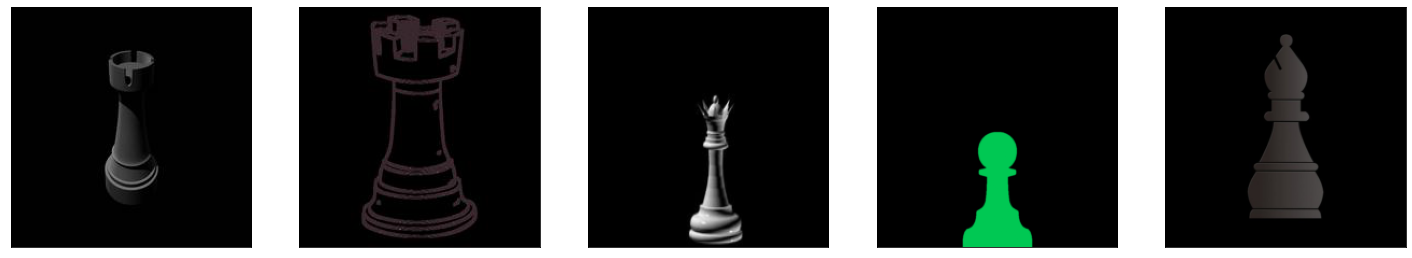

In [10]:
fig = plt.figure(figsize=(25, 5))

for i, key in enumerate(list(black_dict)[:5]):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    plt.imshow(my_test.dataset[key][0].numpy().transpose((1, 2, 0)))

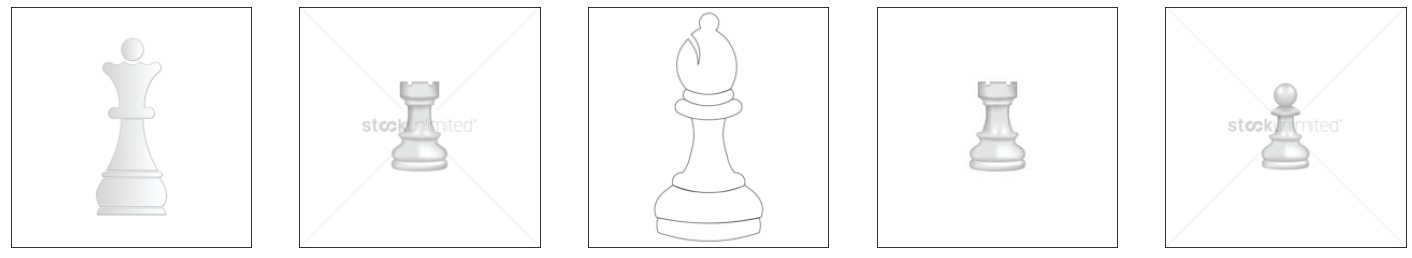

In [11]:
fig = plt.figure(figsize=(25, 5))

for i, key in enumerate(list(black_dict)[-5:]):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    plt.imshow(my_test.dataset[key][0].numpy().transpose((1, 2, 0)))

# Training

In [12]:
def train_model(model, epoch, train_loader, val_loader, criterion,
                optimizer, return_history=False, name_checkpoint='checkpoint_chess.pth'):
    def train(model, data_loader, criterion, optimizer, train_mod):
        loss_total = 0
        correct_total = 0
        total_samples = 0
        
        for data in data_loader:
            X = data[0].to(device)
            y = data[1].to(device)

            pred = model(X)
            loss = criterion(pred, y)

            if train_mod:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
            _, pred = torch.max(pred, 1)
            correct_total += torch.sum(y == pred)
            total_samples += len(y)
            loss_total += loss.item()
        return loss_total / len(data_loader), correct_total / total_samples

    train_history_loss, train_history_acc = [], []
    val_history_loss, val_history_acc = [], []
    best_loss = np.inf
    best_accuracy = 0

    for ep in range(epoch):
        torch.cuda.empty_cache()
        print('-' * 65)
        print(f'Epoch: {ep + 1} |')
        print('-' * 65)
        
        model.train()
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, train_mod=True)
        print(f'Train | loss: {train_loss} | accuracy: {train_accuracy}')
        model.eval()
        val_loss, val_accuracy = train(model, val_loader, criterion, optimizer, train_mod=False)
        print(f'Val | loss: {val_loss} | accuracy: {val_accuracy}')

        if val_loss < best_loss:
            torch.save(model.state_dict(), name_checkpoint)
            best_loss = val_loss
            best_accuracy = val_accuracy

        train_history_loss.append(train_loss)
        train_history_acc.append(train_accuracy.item())
        val_history_loss.append(val_loss)
        val_history_acc.append(val_accuracy.item())

    print('-' * 65)
    print(f'Best loss is {best_loss} | Best accuracy is {best_accuracy}')
    if return_history:
        return train_history_loss, train_history_acc, val_history_loss, val_history_acc

# My_Net







In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 9, 3, padding=1)
        self.conv2 = nn.Conv2d(9, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.max_pool1 = nn.MaxPool2d(4, 4)
        self.max_pool2 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(32 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 5)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.45)
    
    def forward(self, x):
        x = self.max_pool1(self.relu(self.conv1(x)))
        x = self.max_pool1(self.relu(self.conv2(x)))
        x = self.max_pool2(self.relu(self.conv3(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [14]:
model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

num_epoch = 20

In [15]:
history = train_model(model, num_epoch, train_loader, val_loader, criterion,
            optimizer, return_history=True, name_checkpoint='My_net_chess.pth')

-----------------------------------------------------------------
Epoch: 1 |
-----------------------------------------------------------------
Train | loss: 1.606351856029395 | accuracy: 0.20483461022377014
Val | loss: 1.5743275880813599 | accuracy: 0.38461539149284363
-----------------------------------------------------------------
Epoch: 2 |
-----------------------------------------------------------------
Train | loss: 1.6017501643209746 | accuracy: 0.24173028767108917
Val | loss: 1.5782477060953777 | accuracy: 0.41420120000839233
-----------------------------------------------------------------
Epoch: 3 |
-----------------------------------------------------------------
Train | loss: 1.5831084504272 | accuracy: 0.28371500968933105
Val | loss: 1.5437238931655883 | accuracy: 0.2544378638267517
-----------------------------------------------------------------
Epoch: 4 |
-----------------------------------------------------------------
Train | loss: 1.5160776629592434 | accuracy: 0.31

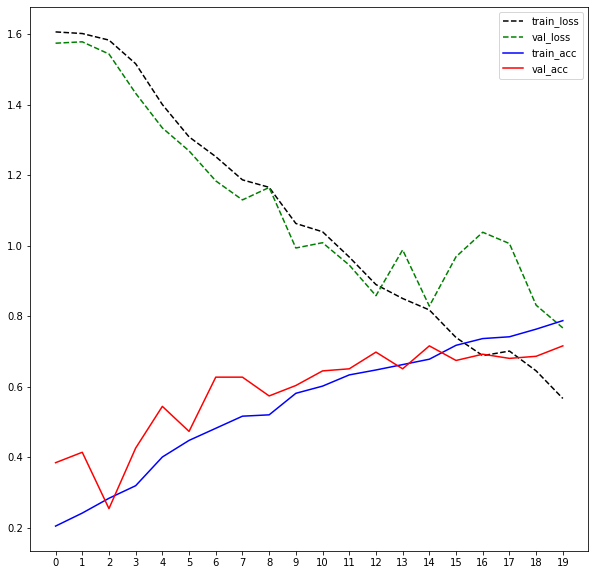

In [16]:
train_loss, train_acc, val_loss, val_acc = history

fig = plt.figure(figsize=(10, 10))
plt.plot(range(num_epoch), train_loss, label='train_loss', color='black', linestyle='dashed')
plt.plot(range(num_epoch), val_loss, label='val_loss', color='green', linestyle='dashed')
plt.plot(range(num_epoch), train_acc, label='train_acc', color='blue')
plt.plot(range(num_epoch), val_acc, label='val_acc', color='red')
plt.xticks(range(num_epoch))
plt.legend()

# ResNet18






In [17]:
model = models.resnet18(pretrained=True)

In [18]:
for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(nn.Linear(512, 256),
                         nn.ReLU(),
                         nn.Linear(256, 5))

In [19]:
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

num_epoch = 40

In [20]:
history = train_model(model, num_epoch, train_loader, val_loader, criterion,
            optimizer, return_history=True, name_checkpoint='ResNet18_chess.pth')

-----------------------------------------------------------------
Epoch: 1 |
-----------------------------------------------------------------
Train | loss: 0.8149149967639735 | accuracy: 0.7302799224853516
Val | loss: 0.5889872491359711 | accuracy: 0.8106508851051331
-----------------------------------------------------------------
Epoch: 2 |
-----------------------------------------------------------------
Train | loss: 0.5131799494565437 | accuracy: 0.838422417640686
Val | loss: 0.37222315072958734 | accuracy: 0.8934911489486694
-----------------------------------------------------------------
Epoch: 3 |
-----------------------------------------------------------------
Train | loss: 0.4170987510094137 | accuracy: 0.8638677000999451
Val | loss: 0.3183692008567353 | accuracy: 0.8875739574432373
-----------------------------------------------------------------
Epoch: 4 |
-----------------------------------------------------------------
Train | loss: 0.19531383046485257 | accuracy: 0.94

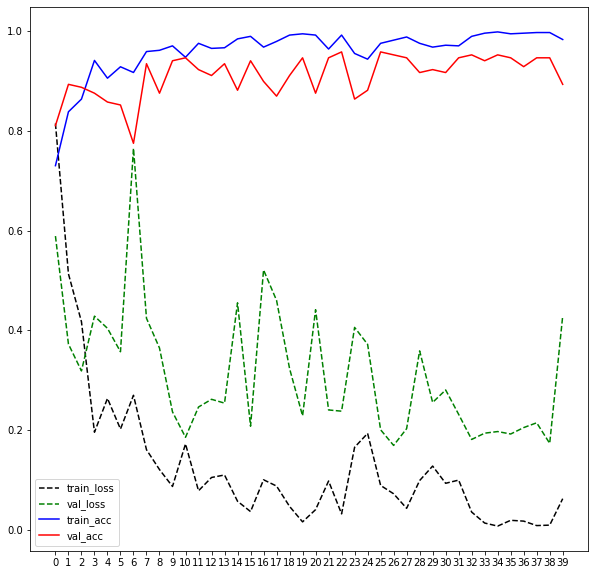

In [21]:
train_loss, train_acc, val_loss, val_acc = history

fig = plt.figure(figsize=(10, 10))
plt.plot(range(num_epoch), train_loss, label='train_loss', color='black', linestyle='dashed')
plt.plot(range(num_epoch), val_loss, label='val_loss', color='green', linestyle='dashed')
plt.plot(range(num_epoch), train_acc, label='train_acc', color='blue')
plt.plot(range(num_epoch), val_acc, label='val_acc', color='red')
plt.xticks(range(num_epoch))
plt.legend()

# ResNet34








In [22]:
model = models.resnet34(pretrained=True)

In [23]:
for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(nn.Linear(512, 256),
                         nn.ReLU(),
                         nn.Linear(256, 5))

In [24]:
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

num_epoch = 15

In [25]:
history = train_model(model, num_epoch, train_loader, val_loader, criterion,
            optimizer, return_history=True, name_checkpoint='ResNet34_chess.pth')

-----------------------------------------------------------------
Epoch: 1 |
-----------------------------------------------------------------
Train | loss: 1.0192370715014862 | accuracy: 0.6246819496154785
Val | loss: 0.8556473479334575 | accuracy: 0.7396450042724609
-----------------------------------------------------------------
Epoch: 2 |
-----------------------------------------------------------------
Train | loss: 0.5818299111543279 | accuracy: 0.830788791179657
Val | loss: 0.640718512237072 | accuracy: 0.7928994297981262
-----------------------------------------------------------------
Epoch: 3 |
-----------------------------------------------------------------
Train | loss: 0.5393057859530954 | accuracy: 0.8409669399261475
Val | loss: 0.6458747219915192 | accuracy: 0.7633135914802551
-----------------------------------------------------------------
Epoch: 4 |
-----------------------------------------------------------------
Train | loss: 0.38467764696388534 | accuracy: 0.8880

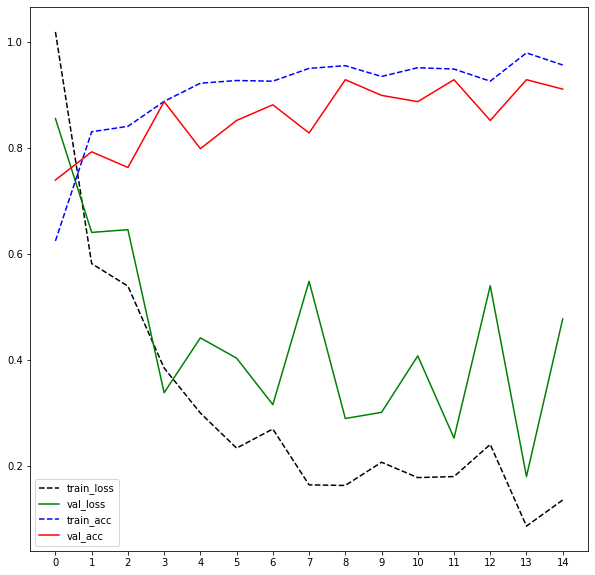

In [26]:
train_loss, train_acc, val_loss, val_acc = history

fig = plt.figure(figsize=(10, 10))
plt.plot(range(num_epoch), train_loss, label='train_loss', color='black', linestyle='dashed')
plt.plot(range(num_epoch), val_loss, label='val_loss', color='green')
plt.plot(range(num_epoch), train_acc, label='train_acc', color='blue', linestyle='dashed')
plt.plot(range(num_epoch), val_acc, label='val_acc', color='red')
plt.xticks(range(num_epoch))
plt.legend()

# ResNet50






In [27]:
model = models.resnet50(pretrained=True)

In [28]:
for param in model.parameters():
    param.requires_grad = True

model.fc = nn.Sequential(nn.Linear(2048, 516),
                         nn.ReLU(),
                         nn.Linear(516, 5))

In [29]:
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

num_epoch = 15

In [30]:
history = train_model(model, num_epoch, train_loader, val_loader, criterion,
            optimizer, return_history=True, name_checkpoint='ResNet50_chess.pth')

-----------------------------------------------------------------
Epoch: 1 |
-----------------------------------------------------------------
Train | loss: 1.5835001757650664 | accuracy: 0.2875317931175232
Val | loss: 4.244438791275025 | accuracy: 0.21893490850925446
-----------------------------------------------------------------
Epoch: 2 |
-----------------------------------------------------------------
Train | loss: 1.2043401517651298 | accuracy: 0.5114504098892212
Val | loss: 1.506157433986664 | accuracy: 0.44378697872161865
-----------------------------------------------------------------
Epoch: 3 |
-----------------------------------------------------------------
Train | loss: 1.0996006700125607 | accuracy: 0.5699745416641235
Val | loss: 2.2048996885617576 | accuracy: 0.5325443744659424
-----------------------------------------------------------------
Epoch: 4 |
-----------------------------------------------------------------
Train | loss: 0.9688160329154043 | accuracy: 0.592

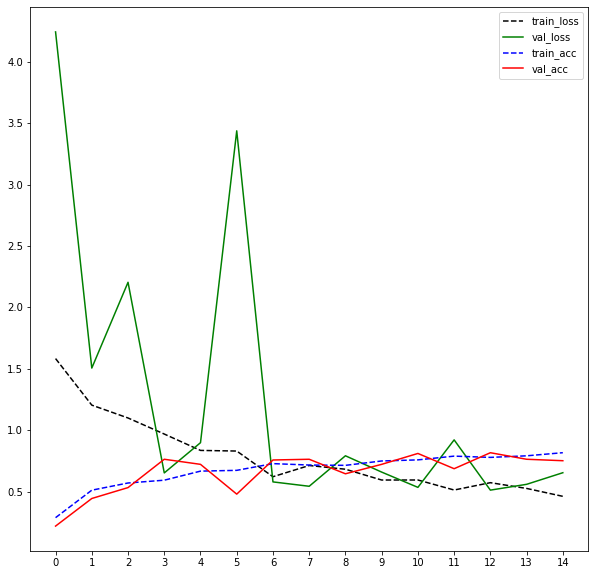

In [31]:
train_loss, train_acc, val_loss, val_acc = history

fig = plt.figure(figsize=(10, 10))
plt.plot(range(num_epoch), train_loss, label='train_loss', color='black', linestyle='dashed')
plt.plot(range(num_epoch), val_loss, label='val_loss', color='green')
plt.plot(range(num_epoch), train_acc, label='train_acc', color='blue', linestyle='dashed')
plt.plot(range(num_epoch), val_acc, label='val_acc', color='red')
plt.xticks(range(num_epoch))
plt.legend()

# Efficientnet_b6





In [32]:
model = models.efficientnet_b6(pretrained=True)

In [33]:
for param in model.parameters():
    param.requires_grad = True

model.classifier = nn.Sequential(nn.Dropout(0.5),
                                 nn.Linear(2304, 516),
                                 nn.ReLU(),
                                 nn.Linear(516, 5))

In [34]:
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

num_epoch = 4

In [ ]:
history = train_model(model, num_epoch, train_loader, val_loader, criterion,
            optimizer, return_history=True, name_checkpoint='efficientnet_b6_chess.pth')

In [36]:
train_loss, train_acc, val_loss, val_acc = history

fig = plt.figure(figsize=(10, 10))
plt.plot(range(num_epoch), train_loss, label='train_loss', color='black', linestyle='dashed')
plt.plot(range(num_epoch), val_loss, label='val_loss', color='green')
plt.plot(range(num_epoch), train_acc, label='train_acc', color='blue', linestyle='dashed')
plt.plot(range(num_epoch), val_acc, label='val_acc', color='red')
plt.xticks(range(num_epoch))
plt.legend()

# Densenet121





In [37]:
model = models.densenet121(pretrained=True)

In [39]:
for param in model.parameters():
    param.requires_grad = True

model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 5))

In [40]:
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

num_epoch = 8

In [41]:
history = train_model(model, num_epoch, train_loader, val_loader, criterion,
            optimizer, return_history=True, name_checkpoint='densenet121_chess.pth')

In [42]:
train_loss, train_acc, val_loss, val_acc = history

fig = plt.figure(figsize=(10, 10))
plt.plot(range(num_epoch), train_loss, label='train_loss', color='black', linestyle='dashed')
plt.plot(range(num_epoch), val_loss, label='val_loss', color='green')
plt.plot(range(num_epoch), train_acc, label='train_acc', color='blue', linestyle='dashed')
plt.plot(range(num_epoch), val_acc, label='val_acc', color='red')
plt.xticks(range(num_epoch))
plt.legend()

# Testing

In [46]:
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(nn.Linear(512, 256),
                         nn.ReLU(),
                         nn.Linear(256, 5))

criterion = nn.CrossEntropyLoss()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [47]:
checkpoint = torch.load('/content/ResNet18_chess.pth')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [48]:
uncorrect_class = []
loss_total = 0
correct = 0
total = 0

model.eval()
for data in test_loader:
    X = data[0].to(device)
    y = data[1].to(device)

    pred = model(X)
    loss = criterion(pred, y)
    _, pred = torch.max(pred, 1)

    correct += torch.sum(pred == y)
    total += y.shape[0]
    loss_total += loss

    for idx, (y, pred) in enumerate(zip(y, pred)):
        if y != pred:
            uncorrect_class.append((X[idx], y, pred))

print(f'Loss: {loss_total / len(test_loader)} | accuracy: {correct / total}')


Loss: 0.6106821894645691 | accuracy: 0.9053254723548889


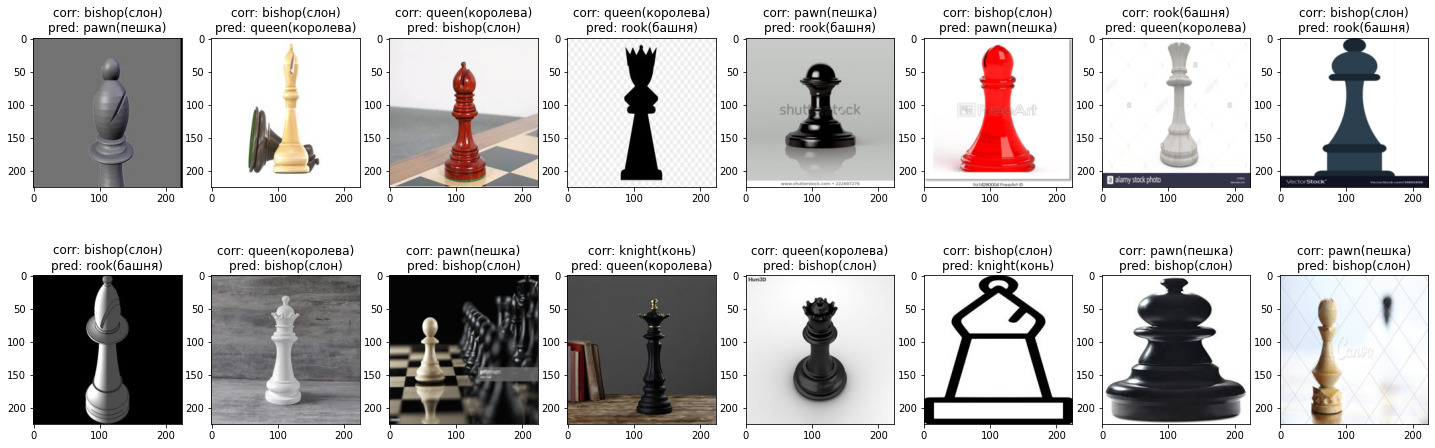

In [49]:
fig = plt.figure(figsize=(25, 8))
num_uncorrect = 18 if len(uncorrect_class) > 18 else len(uncorrect_class)
num_uncorrect = num_uncorrect if num_uncorrect % 2 == 0 else num_uncorrect - 1

for idx in np.arange(num_uncorrect):
    ax = fig.add_subplot(2, num_uncorrect // 2, idx + 1)
    plt.imshow(uncorrect_class[idx][0].to('cpu').numpy().transpose((1, 2, 0)))
    ax.set_title('corr: ' + str(decode_classes[uncorrect_class[idx][1].item()]) + '\n'
                 'pred: ' + str(decode_classes[uncorrect_class[idx][2].item()]))